In [118]:
from itertools import chain, zip_longest
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [119]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

## Probability Density Function for a Normal Distribution

In [120]:
def pdf_normal(x, axis=0):
    mean, std = np.mean(np.array(x), axis=axis), np.std(np.array(x), axis=axis)
    return lambda x: np.exp(-0.5*((x - mean)/std)**2)/(std*np.sqrt(2*np.pi)) 

## Numeric Integrator

In [121]:
def euler(x0=0, dt=0, dy=0, steps=-1, thr=1e-3):
    steps = int(thr/dt) if steps < 1 else steps
    value = np.zeros_like(x0)
    for step in range(steps):
        x0 = x0 + dt
        value = value + dt*dy(x0)

    return value

## Class Conditional Probability Function
A vectorized function, that computes the PDF (Probability Density) and integrates the PDF over an interval $x_i + \Delta_x$ to approximate the conditonal probability $P(x_i | w_j)$

In [122]:
def prob_dist(feature, thr=1e-3):
    return lambda x: euler(x0=x, dy=pdf_normal(feature), dt=1e-5, thr=thr)

## Example

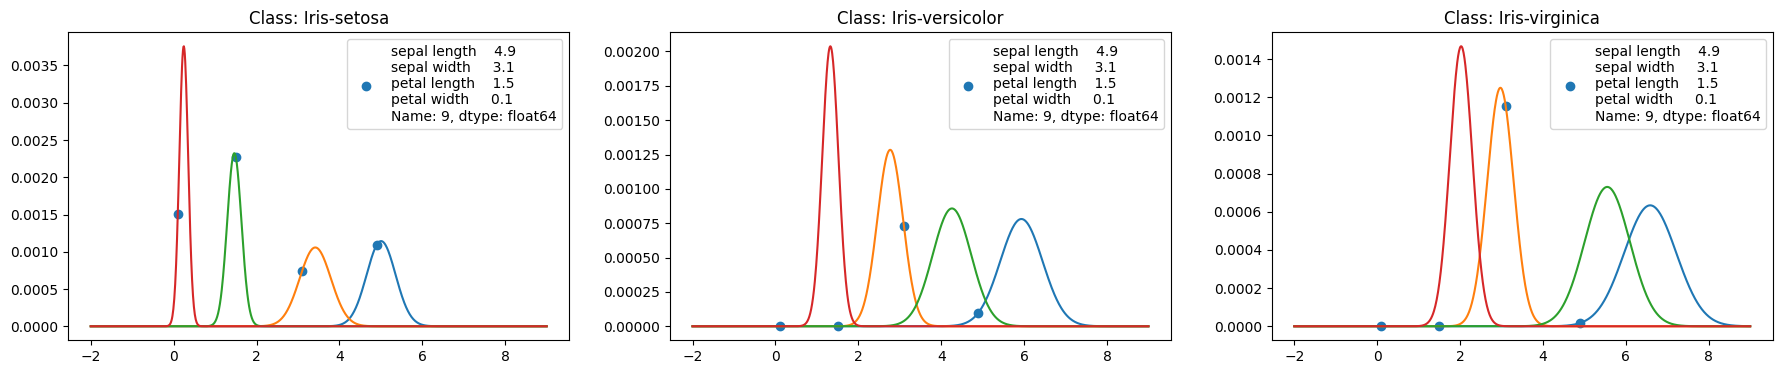

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(22, 4))
groups = list(y.groupby('class').groups.values())
a, c = 5, 1000
arr = np.linspace(-a + 3, a + 4, c)
arrr = np.vstack([arr, arr, arr, arr]).transpose()
test = X.iloc[np.random.randint(0, len(X))]
for _ in range(len(axes)):
    features = X.iloc[groups[_]]
    func =  prob_dist(feature=features, thr=1e-3)
    axes[_].plot(arr, func(arrr))
    axes[_].scatter(test, prob_dist(feature=features, thr=1e-3)(np.array(test)), label=str(test))
    axes[_].set_title(f'Class: {y.iloc[groups[_]].iloc[0].values[0]}')
    axes[_].legend()
plt.show()

In [124]:
class NaiveBayes:
    def __init__(self):
        self.classes = None
    
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):
        if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.DataFrame):
            raise TypeError(f'X is type {type(x)} must be {pd.DataFrame}, y is type {type(y)} must be {pd.DataFrame}')
        
        # Compute the prior for the class probabilities P(y)
        class_probabilities = y.value_counts()/len(y) 
        
        # Extract the classes
        classes = list(chain(*class_probabilities.index))

        # Extract indices
        groups = list(y.groupby(list(y.columns)).groups.values())
        
        # Compute class conditional probabilities P(X | y)
        probabilities = []
        labels = []
        for i, (c, idx) in enumerate(zip(classes, groups)):
            features = x.iloc[idx]
            class_conditionals =  np.prod(prob_dist(feature=features, thr=1e-3)(x), axis=1) * class_probabilities[c]
            class_conditionals /= np.sum(class_conditionals)
            probabilities.append(class_conditionals)
            
        probabilities = np.array(probabilities).transpose()
        return  [classes[_] for _ in np.argmax(pd.DataFrame(probabilities, columns=classes), axis=1)]
        
nb = NaiveBayes()
pred = nb.fit(x=X, y=y)
res = pd.concat([X, y, pd.DataFrame(pred), pd.DataFrame([int(t[0] == p) for t, p in zip(y.values, pred)])], axis=1)
res.columns = [*list(res.columns[:-3]), 'actual', 'pred', 'accurate']

In [125]:
res.accurate.mean()

0.9466666666666667

In [126]:
res

,sepal length,sepal width,petal length,petal width,actual,pred,accurate
0,5.1,3.5,1.4,0.2,Iris-setosa,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,Iris-setosa,1
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,Iris-virginica,1
146,6.3,2.5,5.0,1.9,Iris-virginica,Iris-virginica,1
147,6.5,3.0,5.2,2.0,Iris-virginica,Iris-virginica,1
148,6.2,3.4,5.4,2.3,Iris-virginica,Iris-virginica,1


In [158]:
def plot_result(features = (0, 2)):
    one, two = features
    # Assuming 'res' is your DataFrame and it's already defined
    x = res.iloc[:, one]
    y_ = res.iloc[:, two]
    predictions = res.iloc[:, -2] 
    labels = list(y.values) 
    classes = list(set(predictions))
    color_list = ['red', 'blue', 'green']
    c = {}
    # Plot each point individually
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    for i in range(len(x)):
        color = color_list[classes.index(predictions[i])]
        color2 = color_list[classes.index(labels[i])]
        ax1.plot(x.iloc[i], y_.iloc[i], 'o', color=color)
        ax2.plot(x.iloc[i], y_.iloc[i], 'o', color=color2)
        
    ax1.set_xlabel(x.name)
    ax1.set_ylabel(y_.name)
    ax1.set_title('Prediction')
    
    ax2.set_xlabel(x.name)
    ax2.set_ylabel(y_.name)
    ax2.set_title('Label')
    plt.show()

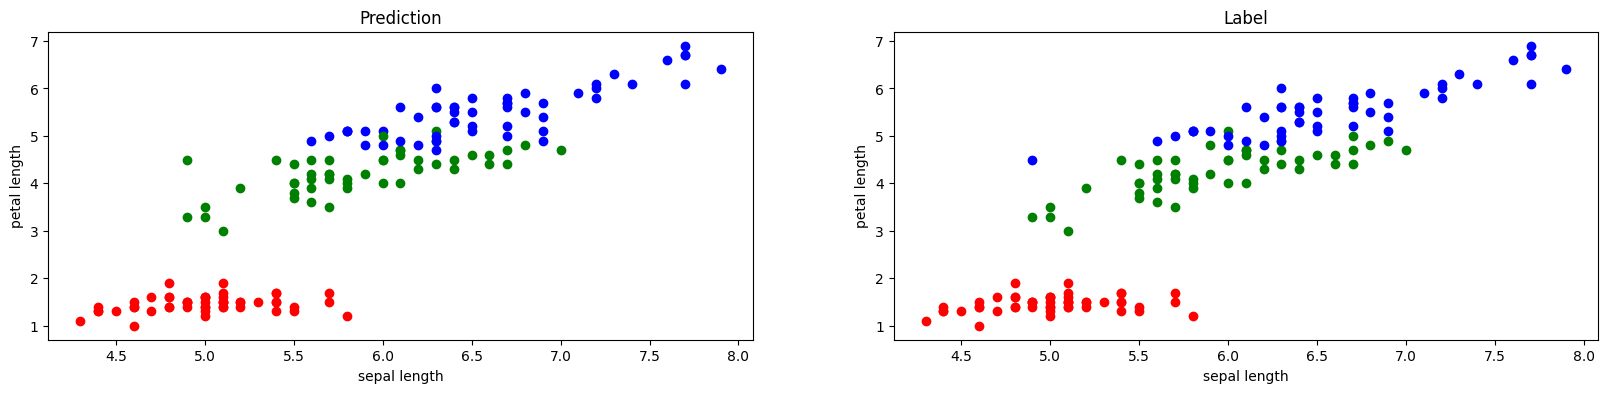

In [165]:
plot_result(features=(0, 2))